In [1]:
import fun as f
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
from math import sqrt, exp
import scipy.linalg as la
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

# 1- Spiral Dataset

In [2]:
# Toy dataset obtained from:
# https://www.gagolewski.com/resources/data/clustering/
data_path = 'data/spiral.data'
labels_path = 'data/spiral.labels'

In [3]:
data_points, data_labels = f.read_and_convert_data(data_path, labels_path)
Npts, coord = data_points.shape

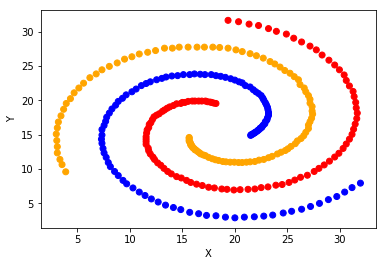

In [4]:
f.scatter_plot_data_set(data_points, data_labels)

In [5]:
W = f.adjacency_matrix(data_points, sigma=0.5)
L_unnormalized =f.unnormalized_graph_Laplacian(W)
L_symmetric = f.normalized_graph_Laplacian(W, matrix = "symmetric")
L_random_walk = f.normalized_graph_Laplacian(W, matrix = "rw")

In [6]:
#Sanity check: Symmetric matrix
np.allclose(L_unnormalized, L_unnormalized.T)

True

## Compute eigenvalues-eigenvectors

In [7]:
eigenvalues, eigenvectors = np.linalg.eig(L_unnormalized)
eigenvalues = eigenvalues.real
eigenvalues.sort()
rearrangedEvalsVecs = sorted(zip(eigenvalues,eigenvectors.T),key=lambda x: x[0])

(-0.05, 0.0055)

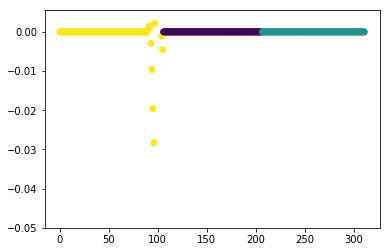

In [8]:
plt.scatter([i for i in range(Npts)], rearrangedEvalsVecs[1][1].T,c=data_labels)
plt.ylim(-0.05, 0.0055)

(-0.05, 0.0055)

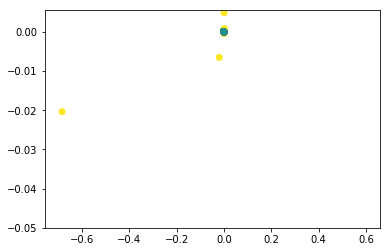

In [9]:
plt.scatter(rearrangedEvalsVecs[1][1], rearrangedEvalsVecs[2][1].T,c=data_labels)
plt.ylim(-0.05, 0.0055)

## Plot first eigenvectors

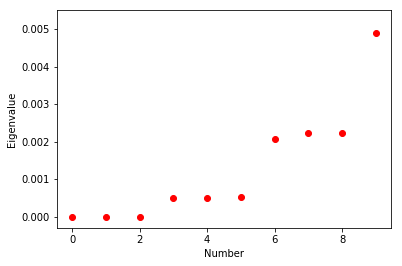

In [10]:
plt.scatter([i for i in range(10)], eigenvalues[0:10],c="red")
plt.ylim(-0.0003, 0.0055)
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')
plt.show()

# 2- Half-moon Dataset

In [11]:
#Generate data
Npts = 35
half_moons_data = datasets.make_moons(n_samples=Npts, noise=.040, random_state=1991)
nodes_position = dict()
for key  in [i for i in range(Npts)]:
    nodes_position[key] = list(half_moons_data[0][key])

In [12]:
W_half_moon = f.adjacency_matrix(half_moons_data[0], sigma=0.5)

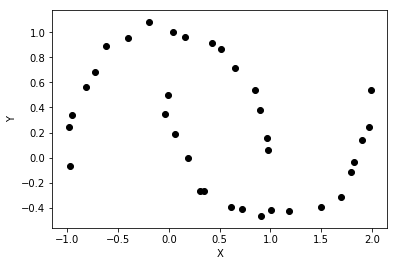

In [13]:
#plot data
f.scatter_plot_data_set(half_moons_data[0], half_moons_data[1], color_clusters = False)

NameError: name 'hm' is not defined

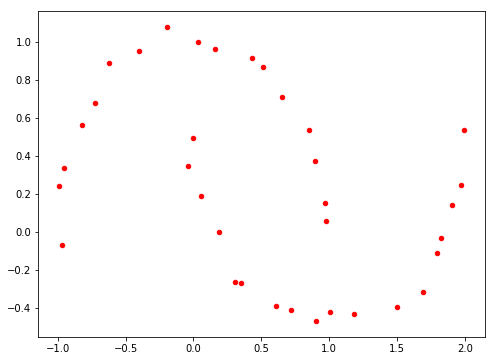

In [14]:
#create graph
hm = f.create_weighted_Graph(W_half_moon)
#Plot graph
f.plot_Graph(hm, nodes_position, 
               title = 'Fully connected graph with edges weighted by the Gaussian similarity function')

In [18]:
A = kneighbors_graph(half_moons_data[0], 3, mode='connectivity', include_self=False)
A= A.toarray()

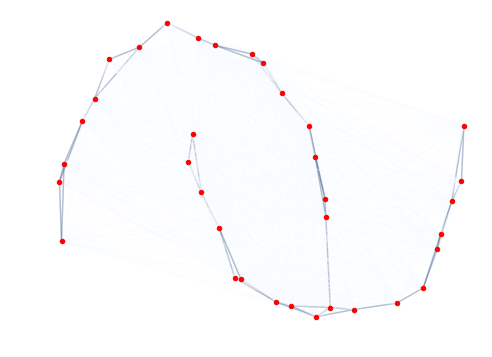

In [20]:
#create graph
km = f.create_weighted_Graph(A)
#Plot graph
f.plot_Graph(km, nodes_position, 
               title = '')

In [21]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(half_moons_data[0])

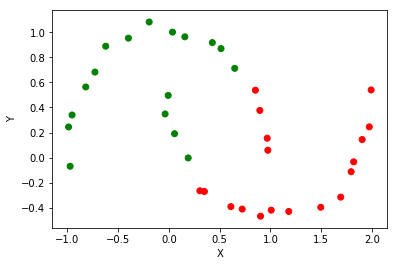

In [22]:
x, y = half_moons_data[0].T
colors = ['red','orange','blue',"green"]
plt.scatter(x,y,c=kmeans.labels_, 
        cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()